# Denoising SWOT data with a first order penalization filter 
* L. Gómez Navarro, E. Cosme, J. Le Sommer and A. Monsimer
* Started on 12 August 2017, last update on 16th January 2018

## Objective

This notebook illustrates the implementation of a first order penalization filter provided by N. Papadakis to filter out noise from SWOT data. It applies the filter for a given lambda and number of iterations. This notebook is adapted for the BOX selected SWOT dataset.  Different tests are shown:
* Gap filling and unmasking
* Pre-conditioning

## Input and output data

SWOT data here comes in the form of a NetCDF files from the SWOT ocean simulator. In this case 1km grid resolution BOX selected dataset is used.  It can be downloaded here:

The file can be downloaded here: 

xxxxxxxx

The output is similar, containing the filtered fields.


## Related links

* https://github.com/SWOTsimulator

# Adapted from:
* 2018-01-12_REG_filter_example_NEWMODEULEVERSION_v2_CLEAN_tmp

# Filtering Method description 
##### (Image denoising, N. Papadakis, March 2017)

### 1. Tikhonov regularization
We consider a noisy image $h_{obs}$ that we want to restore. We assume that the image $h_{obs}$ corresponds to a clean “ground truth” image $h_0$ that has been perturbed by an additional white Gaussian noise $ε$ so that: $h_{obs} = h_0 + ε$. To do so, one can consider the Tikhonov regularization of the gradient of the image and try to minimize the functional:
<br>
<br>
$$ J(h) = \frac{1}{2} \Vert h - h_{obs} \Vert ^2 + \frac{\lambda}{2} \Vert \nabla h \Vert ^2 $$
<br>
<br>
To optimize this convex problem, a simple gradient descent algorithm can be performed.
We have:
<br>
<br>
$$ \langle \nabla J(h),dh \rangle = \lim_{\epsilon\to0} \frac{J (h + \epsilon dh) - J(h)}{\epsilon} $$


### 2. Adaptation to SSH denoising
Let h denote a SSH map. From geostrophic balance one can assume that $v ∝ ∇^⊥ h$, where $v$ is the surface velocity. In this case, one has $ξ ∝ ∆h$, where $ξ$ is the relative vorticity, that is assumed spatially smooth. In the previous model, by regularizing the gradient of $h$, we are looking for a solution where $||∇h||$ is small, i.e. where the norm of the velocity field is small. This may be a bad regularization model.
Hence, a physically sound model to restore a noisy SSH map $h_{obs}$ could be to regularize the gradient of the vorticity, i.e. the gradients of the laplacian of the image:

<br>
$$ J(h) = \frac{1}{2}||h − h_{obs}||^2  +  \frac{λ}{2}||∇∆h||^2 $$
<br>
This problem can still be solved with a gradient descent algorithm that now reads:

<br>
$$h^{k+1} = h^k + τ(h_{obs} − h^k + λ∆∆∆h^k)$$
<br>
, and $τ$ should be taken as: $τ < 1/(1 + 512λ)$ to ensure the convergence of the algorithm.


# Loading the necesssary modules:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from netCDF4 import Dataset
import xarray as xr

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from shutil import copyfile
import os

from scipy import ndimage as nd

# Defining the necessary functions:

In [3]:
def gradi(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])

    M[0:-1,:] = np.subtract(I[1::,:], I[0:-1,:])
    return M

def gradj(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])
    M[:,0:-1] =  np.subtract(I[:,1::], I[:,0:-1])
    return M


In [4]:
def div(px, py): 
    """
    Calculates the divergence of a vector (px, py) and gives M as ouput
    ; where px and py have the some size and are the gradient in x and y respectively 
    of a variable p.
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    """
    m, n = px.shape
    M = np.zeros([m,n])
    Mx = np.zeros([m,n])
    My = np.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M

def np_laplacian(u):
    """
    Calculates the laplacian of u using the divergence and gradient functions and gives 
    as output Ml.
    """
    Ml = div(gradi(u), gradj(u));
    return Ml

def trilaplacian(u):
    u2 = np_laplacian(np_laplacian(np_laplacian(u)))
    
    return u2

In [5]:
def gaussian_with_nans(u, sigma):
    '''
    Evan Mason
    http://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    '''
    assert np.ma.any(u.mask), 'u must be a masked array'
    mask = np.flatnonzero(u.mask)
    #u.flat[mask] = np.nan

    v = u.data.copy()
    #v.flat[mask] = 0
    v[:] = nd.gaussian_filter(v ,sigma=sigma)

    w = np.ones_like(u.data)
    w.flat[mask] = 0
    w[:] = nd.gaussian_filter(w, sigma=sigma)

    return v/w

In [6]:
sys.path.insert(0, "/Users/laura/PhD_private/develop/SWOT/")
import SWOT_data_class

# Loading test 7: (i.e. FMA box dataset)

In [7]:
_datadir = '/Users/laura/PhD_private/data/SWOT_box_selections/'
_namdescr = '/Users/laura/src/git/swotsimulator/swotoutput/FASTtest07/' + 'swot_simulator.output'
_namfiles_simu = 'MED_1km_nogap_FMA13_swotFastPhase_BOX_'

In [8]:
swot_pass_t7_b = SWOT_data_class.swot_pass(_datadir, _namfiles_simu, _namdescr)

In [9]:
swotfiles = swot_pass_t7_b.get_list_of_swotfiles()

In [10]:
print swotfiles[0]
swot_pass_t7_b.read_data_ncfile_box(swotfiles[0])

/Users/laura/PhD_private/data/SWOT_box_selections/MED_1km_nogap_FMA13_swotFastPhase_BOX_c01_p009.nc


In [11]:
swot_pass_t7_b.box = [2., 5., 37., 40.]

# Region to filter:

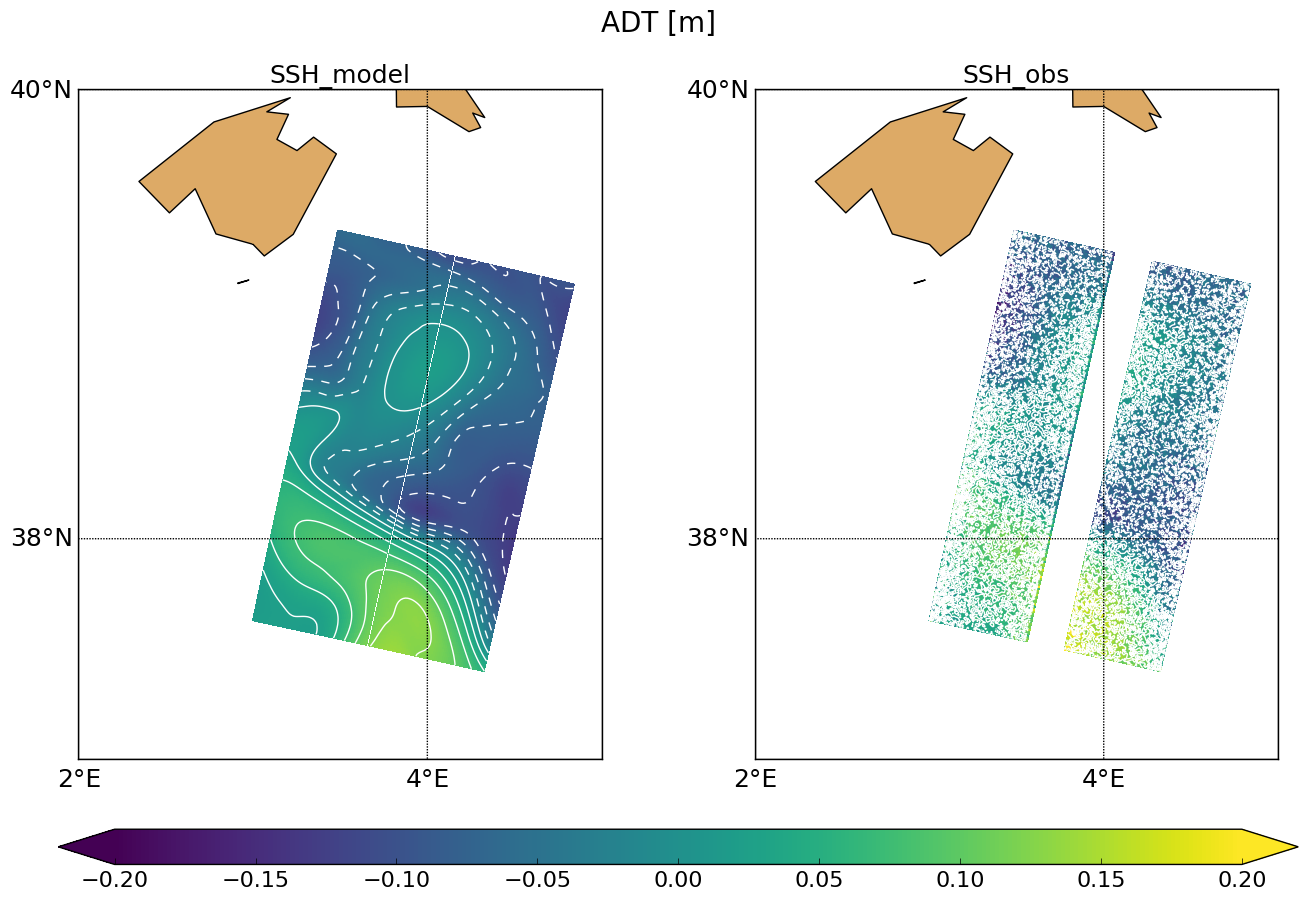

In [12]:
vmin = -.2
vmax = +.2
plt.figure(figsize = (16, 10))

ax1, ax2 = swot_pass_t7_b.plot_model_vs_obs(swot_pass_t7_b.SSH_model, swot_pass_t7_b.SSH_obs, vmin, vmax
                , cmap='viridis', extend_opt = 'both', land=1, plotstyle='1', levels=np.arange(vmin, vmax, .025))

ax1.set_title('SSH_model', size=18)
ax2.set_title('SSH_obs', size=18)
plt.suptitle('ADT [m]', size=20)
plt.show()

# Now using the penalization_filter module to read and filter the data:

In [13]:
##=================Preparing the SWOT data arrays===============

# 1. Making SWOT array organized as (lon, lat) a.k.a., (x, y): 
## Not sure how to check this: --> for now ok, boxes saves as x, yso no need for this step
"""
lon = np.transpose(lon)
lat = np.transpose(lat)
SSH_model = np.transpose(SSH_model)
SSH_obs = np.transpose(SSH_obs)
"""

# 2. Check longitude in -180 : +180 format:
if any(xlo < 0 for xlo in swot_pass_t7_b.lon):
    swot_pass_t7_b.lon[swot_pass_t7_b.lon > 180] -= 360 

# 3. Flipping the SWOT array if necessary: 
# So that lon increases from left to right and lat from bottom to top 
# (depends on if pass is ascending or descending)

lon_dif = swot_pass_t7_b.lon[1,0] - swot_pass_t7_b.lon[0,0]
lat_dif = swot_pass_t7_b.lat[0,1] - swot_pass_t7_b.lat[0,0]

# Need to revise below , above already adapted for datasets oragnized as x,y instead of y,x
if (lat_dif<0):
    print 'flipped variables created'
    ## Ascending pass (pass 22 for in the fast-sampling phase)        
    lon = np.flipud(swot_pass_t7_b.lon)
    lat = np.flipud(swot_pass_t7_b.lat)
    SSH_model = np.flipud(swot_pass_t7_b.SSH_model)
    SSH_obs = np.flipud(swot_pass_t7_b.SSH_obs)

elif (lon_dif<0):
    print 'flipped variables created'
    ## Descending pass (pass 9 for in the fast-sampling phase)
    lon = np.fliplr(swot_pass_t7_b.lon)
    lat = np.fliplr(swot_pass_t7_b.lat)
    SSH_model = np.fliplr(swot_pass_t7_b.SSH_model)
    SSH_obs = np.fliplr(swot_pass_t7_b.SSH_obs)

    
# 3. Fixing the SWOT grid (regular longitude increments, i.e., no jump in swath gap or repeated nadir values)
# At a 1km resolution, should have a size of 121 across track (size of first dim after transposing)    

xx, yy = swot_pass_t7_b.lon.shape
if (swot_pass_t7_b.lon[(xx/2)-1, 0] == swot_pass_t7_b.lon [xx/2, 0]): # this only happens
# when simulation is done with no gap
    print '_nogap variables created'
    # if no gap simulaton case need to eliminate repeated nadir value
    lon_nogap = np.delete(swot_pass_t7_b.lon, (xx/2), axis=0)
    lat_nogap = np.delete(swot_pass_t7_b.lat, (xx/2), axis=0)
    SSH_model_nogap = np.delete(swot_pass_t7_b.SSH_model, (xx/2), axis=0)
    SSH_obs_nogap = np.delete(swot_pass_t7_b.SSH_obs, (xx/2), axis=0)
    x_ac_nogap = np.delete(swot_pass_t7_b.x_ac, (xx/2), axis=0)
    
"""
check need of this below:
# Obtain full land mask:
SSH_model_nogap = np.ma.masked_invalid(SSH_model_nogap)    
SSH_obs_nogap = np.ma.masked_invalid(SSH_obs_nogap)   
mask_land = SSH_obs_nogap.mask

# Convert gap values to 0:
gap_indices = np.where((x_ac_nogap > -10) & (x_ac_nogap < 10))
SSH_model_nogap[gap_indices[0]] = gap_values
SSH_obs_nogap[gap_indices[0]] = gap_values
"""

# 5. Masking the SWOT outputs
## 5.1. Change masked values to 0:
mask_gap = swot_pass_t7_b.SSH_obs.mask 

swot_pass_t7_b.SSH_model[mask_gap] = 0. 
swot_pass_t7_b.SSH_obs[mask_gap] = 0. 

## 5.2. Converting variables to masked array
SSH_model_ma = np.ma.masked_array(swot_pass_t7_b.SSH_model, mask_gap)
SSH_obs_ma = np.ma.masked_array(swot_pass_t7_b.SSH_obs, mask_gap)

## 5.3. Applying the gaussian filter:

sigma = 10 # --> this sigma?
SSH_model_gausf = gaussian_with_nans(SSH_model_ma, sigma)
SSH_obs_gausf = gaussian_with_nans(SSH_obs_ma, sigma)

## 5.4 Assigning the gaussian filtered data to the gap:

SSH_model_gap_full = SSH_model_ma.copy()
SSH_obs_gap_full = SSH_obs_ma.copy()

SSH_model_gap_full[mask_gap] = SSH_model_gausf[mask_gap]
SSH_obs_gap_full[mask_gap] = SSH_obs_gausf[mask_gap] # or leave it as SSH_obs_nogap.mask? and one variable less?

# No need of this step here for this dataset, will implement this check later:
"""
# 5. Creating the gap values array if necessary:
# The half-swath gap values will be set to 0 and masked.

SWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km
gap_size = 20. # size of the the half-swath gap in km
gap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value
gap_values = np.ma.zeros((gap_pixels, yy))
gap_values.mask = True
gap_values.fill_value = 0
"""


/Users/laura/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


'\n# 5. Creating the gap values array if necessary:\n# The half-swath gap values will be set to 0 and masked.\n\nSWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km\ngap_size = 20. # size of the the half-swath gap in km\ngap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value\ngap_values = np.ma.zeros((gap_pixels, yy))\ngap_values.mask = True\ngap_values.fill_value = 0\n'

# Filtering:

In [14]:
def penalization_filter(var=SSH_obs_gap_full, mask_of_data=mask_gap, var_obs=SSH_obs_ma, lambd=40
              , regularization_model=1, iter_max=500, epsilon=0.000001):
    '''
    SSH_obs_gap
    -Input(s):
    --var = variable to be filtered
    Default = 
    --mask_of_data = array of True and False values.  0 when land or swath gap values.
    Default = 
    --var_obs = orginal data without filling the masked values 
    --lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  
    This parameter needs to be adapted to the regularization model. 
    --regularization_model = 0 if Tikhonov regularization (first order penalization, i.e. gradient penalization) 
    and 1 if third order penalization (regularization of vorticity)
    --iter_max = maximum number of iterations in case it takes very long to converge
    --epsilon = 
    -Output(s):
    --ima1 = filtered image
    --itern = number of iterations realized until convergence
    '''
    
    ima0 = var
    ima_obs = var_obs
    
    mask01 = np.ones_like(var)
    mask01[mask_of_data] = 0
    
    if regularization_model == 0:
        tau = 1./(8*lambd)
        operator = np_laplacian
    elif regularization_model == 1:
        tau=1./(512*lambd)
        operator = trilaplacian
    else:
        print "Undefined regularization model"
    
    itern = 1
    ima1 = ima0 + tau*(mask01 * (ima_obs - ima0) + lambd*operator(ima0))

    norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
    norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
    conv_crit = norm_minus / norm_ima0

    while (conv_crit > epsilon) and (itern < iter_max):
        ima0 = np.copy(ima1)
        itern = itern + 1
        ima1 = ima0 + tau*(mask01 * (ima_obs - ima0) + lambd*operator(ima0))
        norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
        norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
        conv_crit = norm_minus / norm_ima0
            
    return ima1, itern


# in this notebook (in contrast to 28/11)
* mask_gap instead of mask_gap_land (no land in this dataset)
* SSH_obs_gap is SSH_obs_ma, but it does not have fill_value set to 0, maybe important?

In [15]:
filt_SSH_model_v2, itern  = penalization_filter(var=SSH_model_gap_full, mask_of_data=mask_gap, var_obs=SSH_model_ma, lambd=40, regularization_model=1, iter_max=500, epsilon=0.000001)
filt_SSH_obs_v2, itern    = penalization_filter()

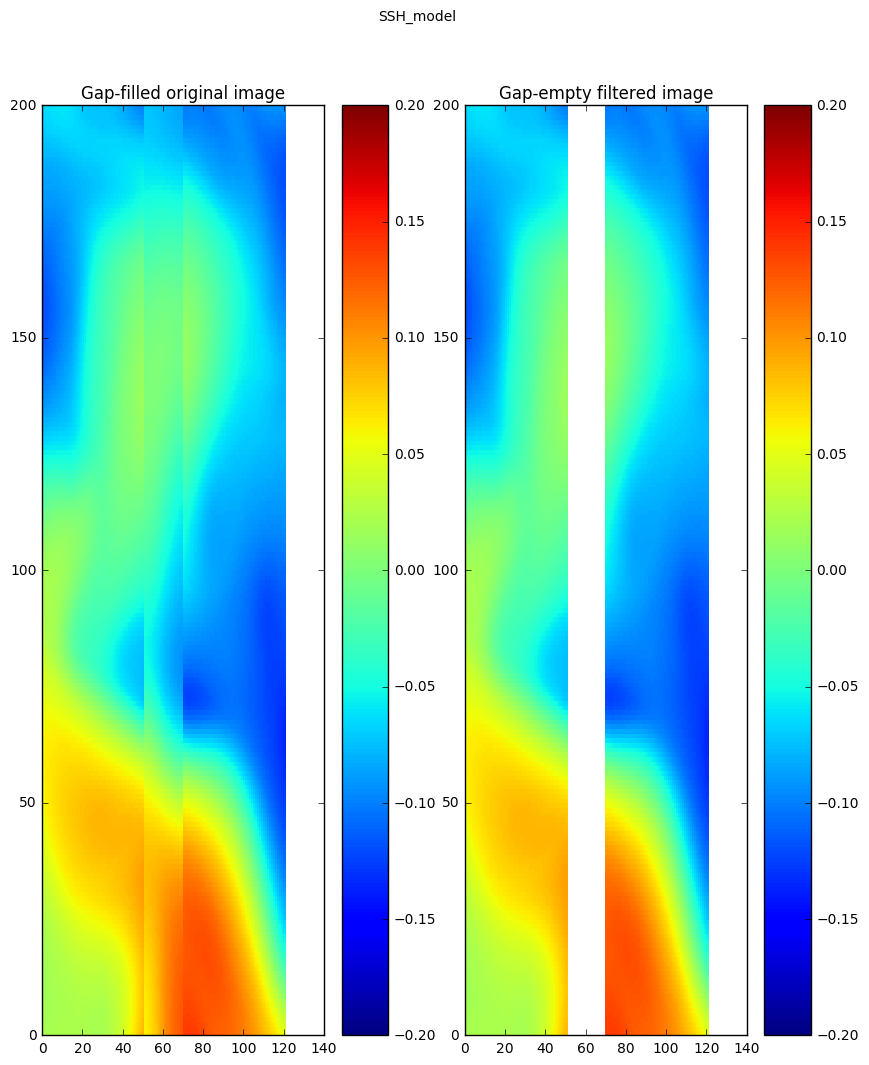

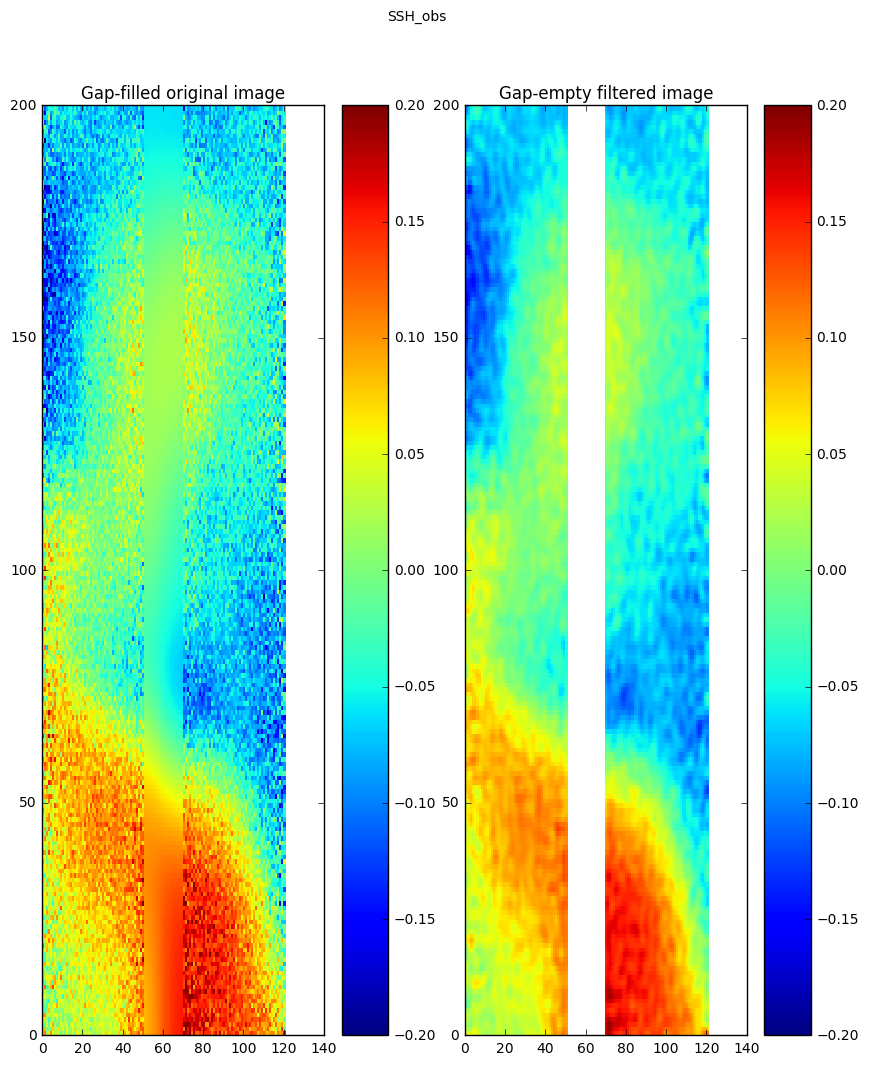

In [16]:
plt.figure(figsize=(10,12))
ax1 = plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
ax1.set_title('Gap-filled original image')
ax2 = plt.subplot(122)
plt.pcolor(filt_SSH_model_v2.T, vmin=-.2, vmax=.2)
plt.colorbar()
ax2.set_title('Gap-empty filtered image')
plt.suptitle('SSH_model')

plt.figure(figsize=(10,12))
ax1 = plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
ax1.set_title('Gap-filled original image')
ax2 = plt.subplot(122)
plt.pcolor(filt_SSH_obs_v2.T, vmin=-.2, vmax=.2)
plt.colorbar()
ax2.set_title('Gap-empty filtered image')
plt.suptitle('SSH_obs')


### Unmasking the gap of the filtered image:

In [17]:
filt_SSH_model_v2.mask = False
filt_SSH_obs_v2.mask = False

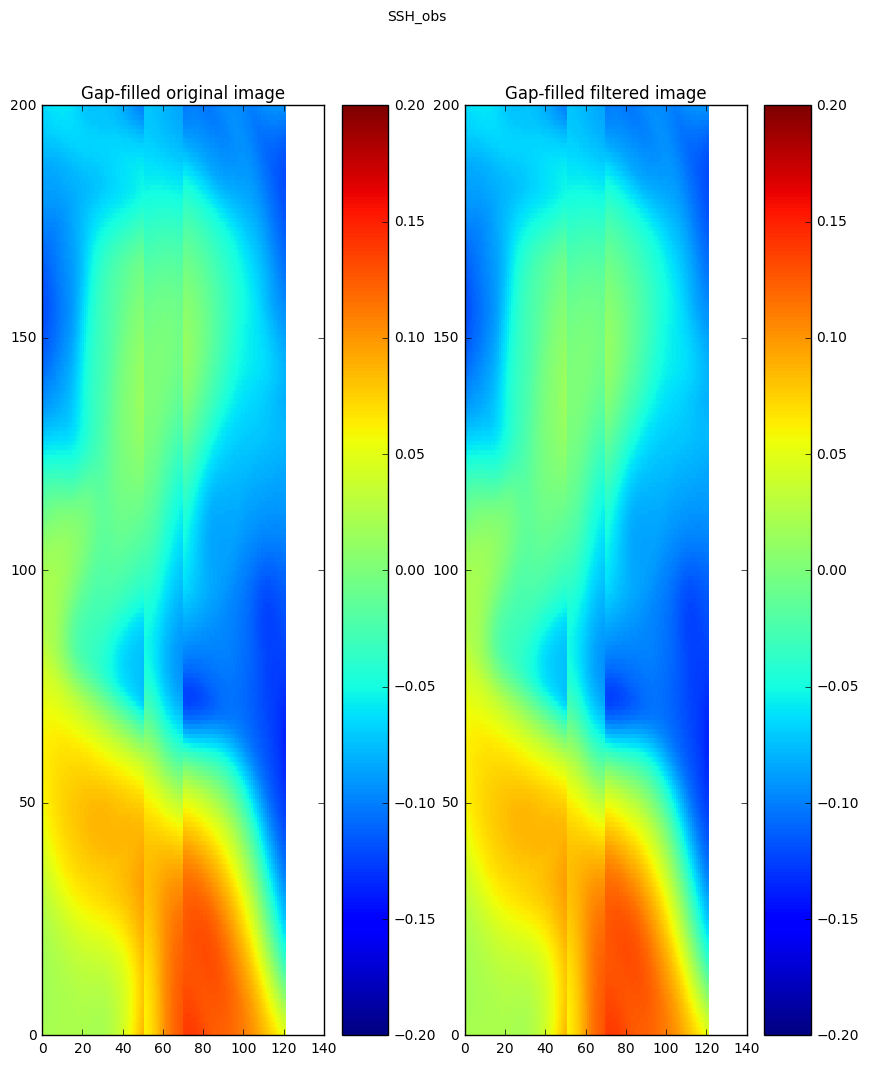

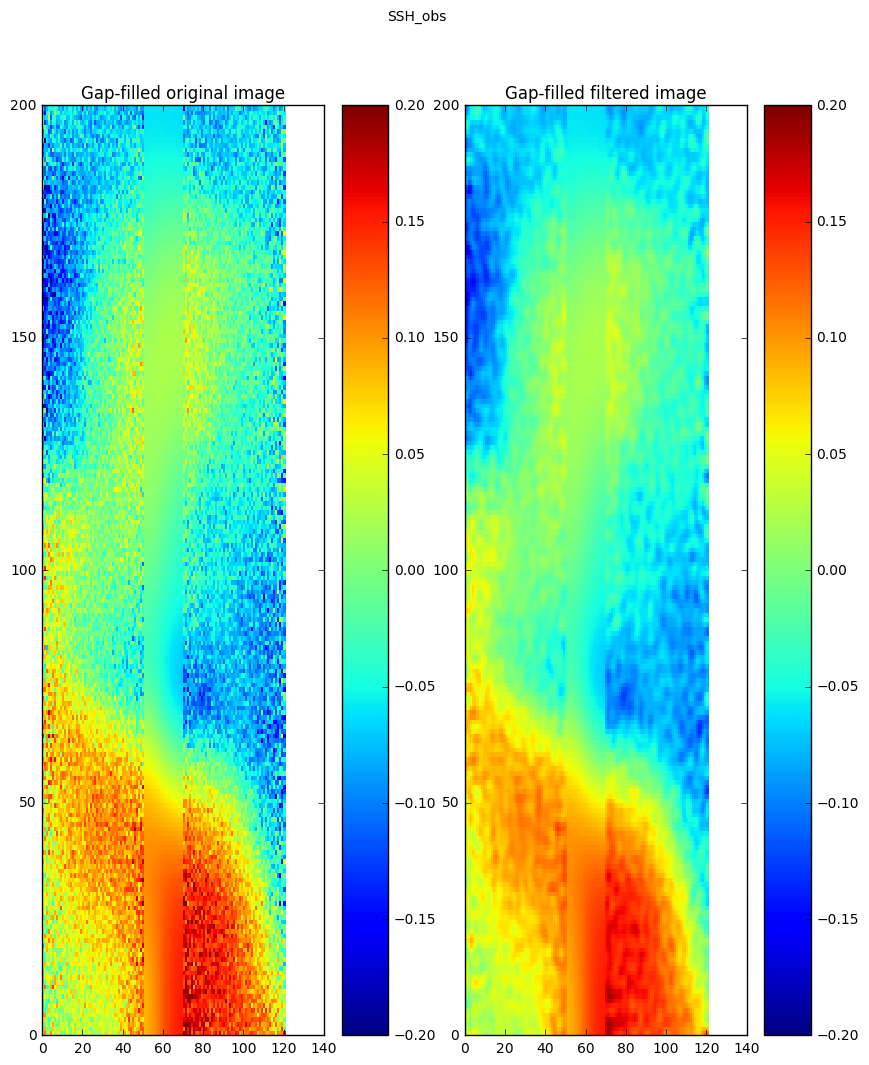

In [18]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled original image')
plt.subplot(122)
plt.pcolor(filt_SSH_model_v2.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled filtered image')
plt.suptitle('SSH_obs')

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled original image')
plt.subplot(122)
plt.pcolor(filt_SSH_obs_v2.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled filtered image')
plt.suptitle('SSH_obs')

## --> need to improve the gap-filling with the gaussian filter 

# Using now as pre-conditioning the gaussian filtered image (whole image, not just the gap):

In [19]:
filt_SSH_model_v3, itern  = penalization_filter(var=SSH_model_gausf, mask_of_data=mask_gap, var_obs=SSH_model_ma, lambd=40, regularization_model=1, iter_max=500, epsilon=0.000001)
filt_SSH_obs_v3, itern    = penalization_filter(var=SSH_obs_gausf, mask_of_data=mask_gap, var_obs=SSH_obs_ma, lambd=40, regularization_model=1, iter_max=500, epsilon=0.000001)

In [20]:
filt_SSH_model_v3.mask = False
filt_SSH_obs_v3.mask = False

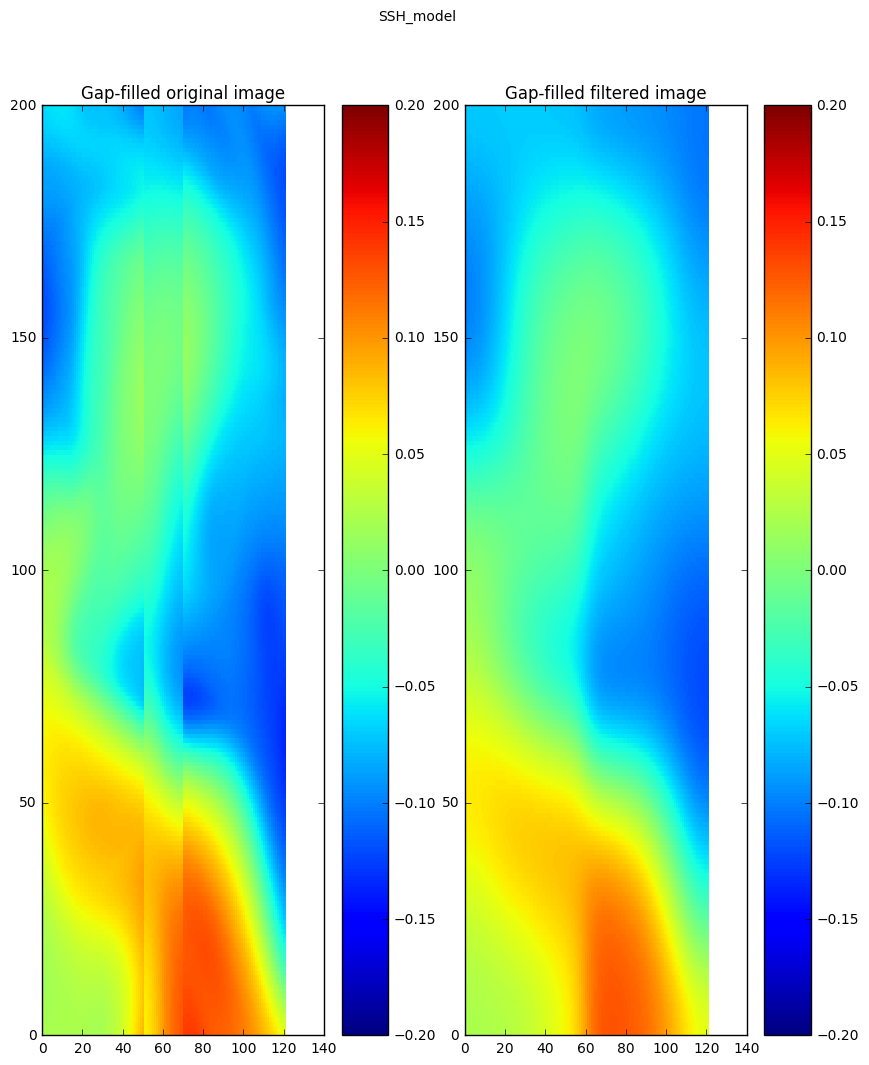

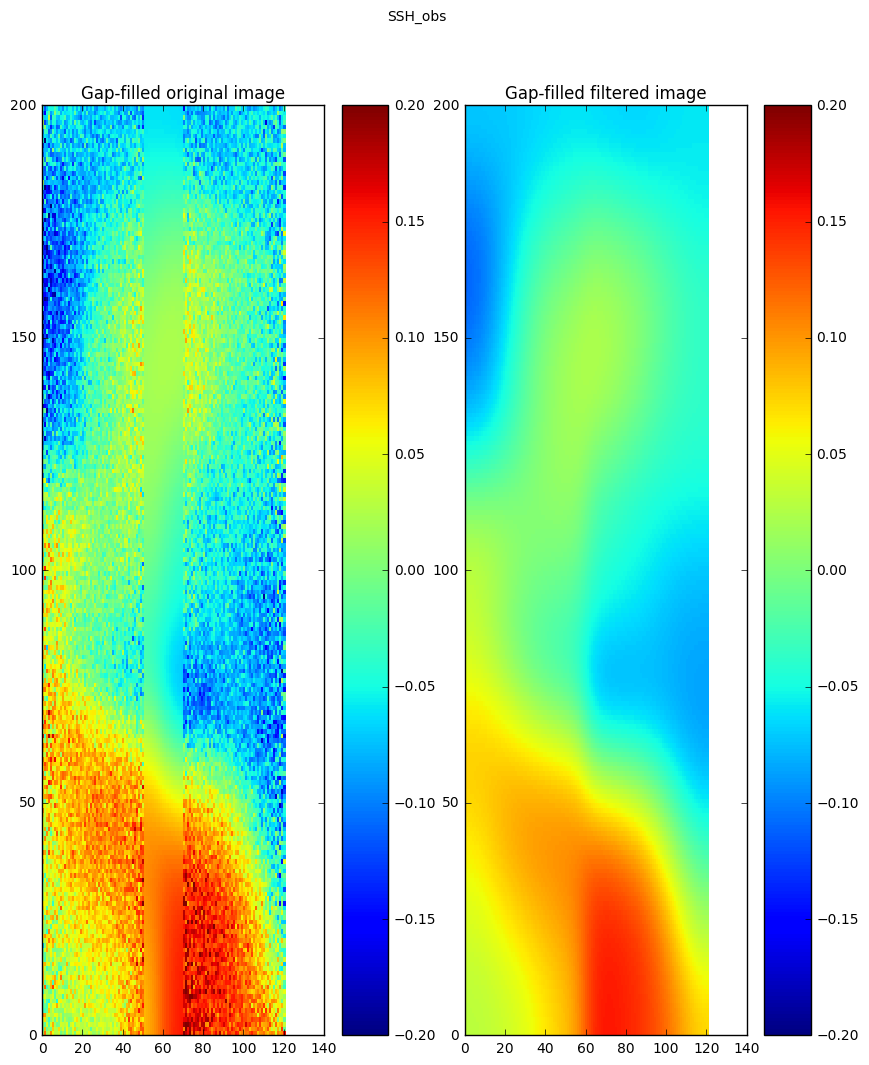

In [21]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled original image')
plt.subplot(122)
plt.pcolor(filt_SSH_model_v3.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled filtered image')
plt.suptitle('SSH_model')

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled original image')
plt.subplot(122)
plt.pcolor(filt_SSH_obs_v3.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.title('Gap-filled filtered image')
plt.suptitle('SSH_obs')

# --> with same filtering parameters, pre-conditiong with the gaussian image, the filtering of SSH_obs is greater and we seem to recover nearly the same image as with SSH_model